In [14]:
import sys
from os import path
import os
from dotenv import load_dotenv

load_dotenv()
sys.path.append(path.dirname(os.getcwd()))


In [ ]:
import json
import p&as as pd
from project.models import YouTubeVideoInfo

with open("/home/leoli/Uni/Polimi/Thesis/master-thesis/data/youtube-common-10k/videos_infos.json", "r") as json_file:
    videos = [YouTubeVideoInfo.from_json(v) for v in json.load(json_file)]

print(len(videos))

9218


In [42]:
import langdetect
from project.utils.subtitles_utils import text_from_subtitles

def detect_language(video: YouTubeVideoInfo) -> str | None:
    try:
        return langdetect.detect(video.description)
    except Exception as e:
        pass
    if video.subtitles:
        try: 
            return langdetect.detect(text_from_subtitles(video.subtitles))
        except Exception as e:
            pass
    if video.auto_subtitles:
        try:
            return langdetect.detect(text_from_subtitles(video.auto_subtitles))
        except Exception as e:
            pass
    try:
        return langdetect.detect(video.title)
    except Exception as e:
        return None


english_videos = [video for video in videos if detect_language(video) == "en"]

In [40]:
english_videos = tmp


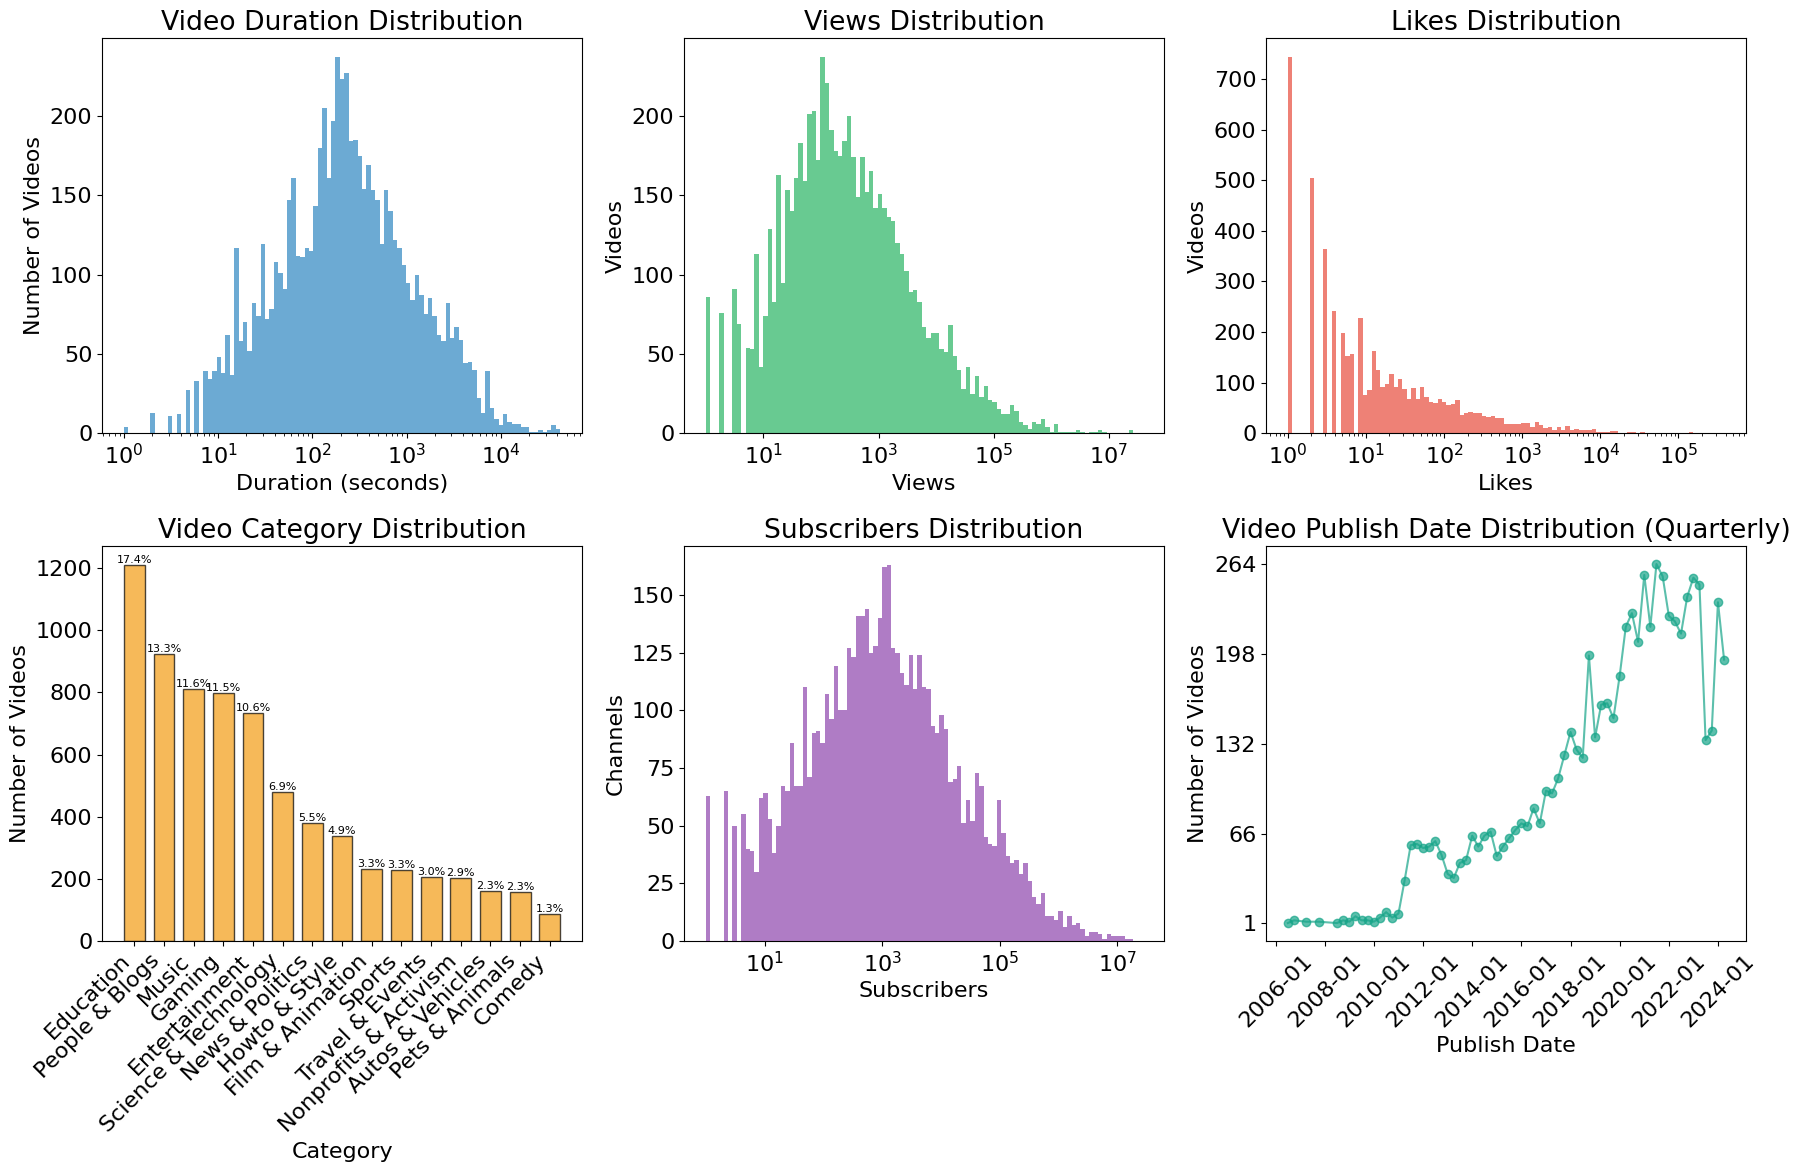

In [49]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
import pandas as pd

plt.rcParams.update({"font.size": 16})

#english_videos = [video for video in english_videos if video.publish_date <= "2022-12-13"]

# Extract data
publish_dates = [video.publish_date for video in english_videos]
views = [video.view_count for video in english_videos]
likes = [video.like_count for video in english_videos if video.like_count]
categories = [video.categories[0] for video in english_videos]
channel_subs = list({video.channel_id: video.channel_subscribers for video in english_videos if video.channel_subscribers}.values())
durations = [video.duration_s for video in english_videos]

# Define log bins
def log_bins(data, num_bins=100):
    min_val = max(min(data), 1)  # Ensure no zero values
    max_val = max(data)
    return np.logspace(np.log10(min_val), np.log10(max_val), num_bins)

# Aggregate publish dates by quarter
df_dates = pd.DataFrame({'publish_date': publish_dates})
df_dates['publish_date'] = pd.to_datetime(df_dates['publish_date'])
df_dates = df_dates.groupby(df_dates['publish_date'].dt.to_period('Q')).size()

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Define color palette
colors = ["#2E86C1", "#28B463", "#E74C3C", "#F39C12", "#8E44AD", "#17A589"]

# Duration Distribution (log bins)
axes[0, 0].hist(durations, bins=log_bins(durations), color=colors[0], alpha=0.7)
axes[0, 0].set_xscale('log')
axes[0, 0].set_title("Video Duration Distribution")
axes[0, 0].set_xlabel("Duration (seconds)")
axes[0, 0].set_ylabel("Number of Videos")

# Views (log bins)
axes[0, 1].hist(views, bins=log_bins(views), color=colors[1], alpha=0.7)
axes[0, 1].set_xscale('log')
axes[0, 1].set_title("Views Distribution")
axes[0, 1].set_xlabel("Views")
axes[0, 1].set_ylabel("Videos")

# Likes (log bins)
axes[0, 2].hist(likes, bins=log_bins(likes), color=colors[2], alpha=0.7)
axes[0, 2].set_xscale('log')
axes[0, 2].set_title("Likes Distribution")
axes[0, 2].set_xlabel("Likes")
axes[0, 2].set_ylabel("Videos")


unique_categories, category_counts = np.unique(categories, return_counts=True)
sorted_indices = np.argsort(category_counts)[::-1]  # Sort descending
sorted_categories = np.array(unique_categories)[sorted_indices]
sorted_counts = np.array(category_counts)[sorted_indices]
total_videos = sum(sorted_counts)
percentages = (sorted_counts / total_videos) * 100

bars = axes[1, 0].bar(sorted_categories, sorted_counts, color=colors[3], alpha=0.7, edgecolor="black", width=0.7)
axes[1, 0].set_title("Video Category Distribution")
axes[1, 0].set_xlabel("Category")
axes[1, 0].set_ylabel("Number of Videos")
axes[1, 0].set_xticks(range(len(sorted_categories)))  # Align labels with ticks
axes[1, 0].set_xticklabels(sorted_categories, rotation=45, ha="right")  # Align text properly

# Add percentage labels on top of bars
for bar, pct in zip(bars, percentages):
    height = bar.get_height()
    axes[1, 0].text(bar.get_x() + bar.get_width() / 2, height, f"{pct:.1f}%", ha='center', va='bottom', fontsize=8)

# Subscribers (log bins)
axes[1, 1].hist(channel_subs, bins=log_bins(channel_subs), color=colors[4], alpha=0.7)
axes[1, 1].set_xscale('log')
axes[1, 1].set_title("Subscribers Distribution")
axes[1, 1].set_xlabel("Subscribers")
axes[1, 1].set_ylabel("Channels")

# Time Distribution (aggregated & line plot with quarterly aggregation)
df_dates.index = df_dates.index.to_timestamp()  # Convert PeriodIndex to datetime
axes[1, 2].plot(df_dates.index, df_dates.values, color=colors[5], marker='o', linestyle='-', alpha=0.7)
axes[1, 2].set_title("Video Publish Date Distribution (Quarterly)")
axes[1, 2].set_xlabel("Publish Date")
axes[1, 2].set_ylabel("Number of Videos")

# Format x-axis for dates with fewer labels
axes[1, 2].xaxis.set_major_locator(mdates.AutoDateLocator())
axes[1, 2].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
axes[1, 2].tick_params(axis='x', rotation=45)

# Reduce y-axis labels for the time plot
y_min, y_max = df_dates.min(), df_dates.max()
axes[1, 2].set_yticks(np.linspace(y_min, y_max, 5, dtype=int))

plt.tight_layout()
plt.savefig("itw_analysis.svg", bbox_inches="tight")
plt.show()


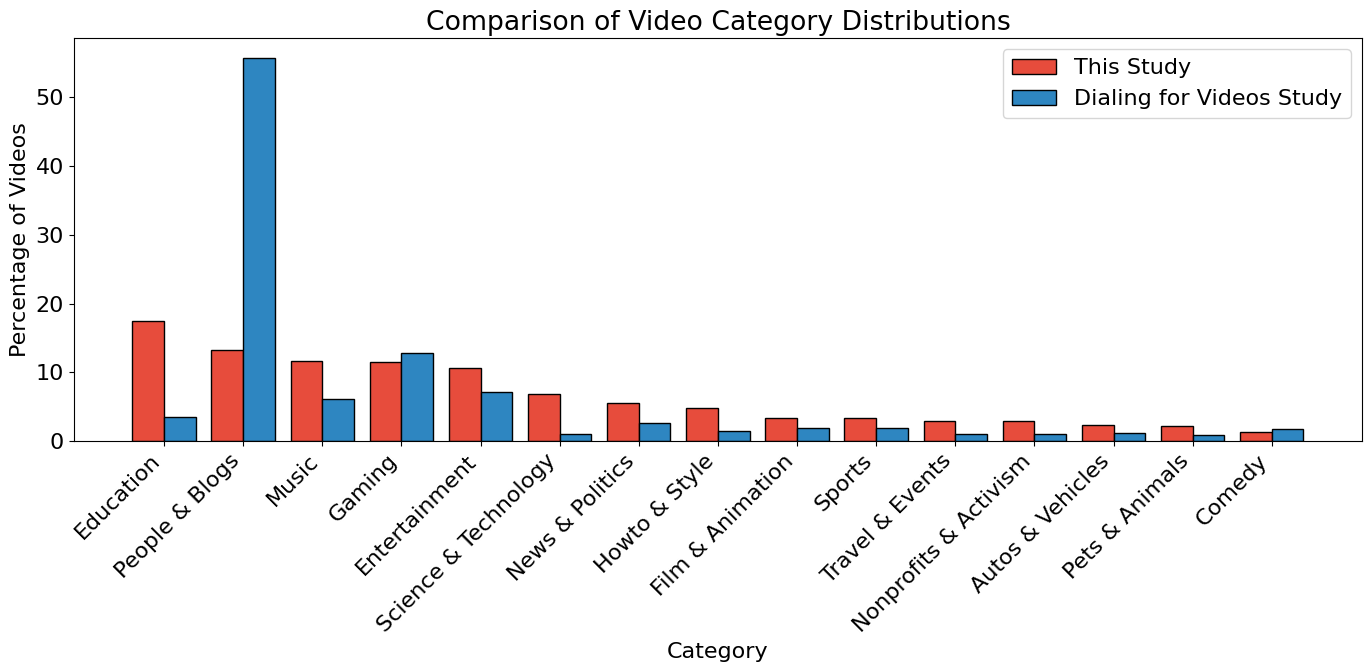

In [50]:
import numpy as np
import matplotlib.pyplot as plt

# Category Distribution from "Dialing for Videos" Study
category_distribution_dialing_for_videos = {
    "Autos & Vehicles": 1.18,
    "Comedy": 1.82,
    "Education": 3.43,
    "Entertainment": 7.11,
    "Film & Animation": 1.95,
    "Gaming": 12.78,
    "Howto & Style": 1.47,
    "Music": 6.11,
    "News & Politics": 2.67,
    "Nonprofits & Activism": 0.97,
    "People & Blogs": 55.81,
    "Pets & Animals": 0.81,
    "Science & Technology": 0.97,
    "Sports": 1.92,
    "Travel & Events": 1.01
}
# Extract your dataset's category distribution (convert to percentages)
unique_categories, category_counts = np.unique(categories, return_counts=True)
total_videos = sum(category_counts)
category_distribution_your_study = {
    cat: (count / total_videos) * 100 for cat, count in zip(unique_categories, category_counts)
}

# Merge both distributions into a DataFrame for easy plotting
import pandas as pd

df_dialing = pd.DataFrame(list(category_distribution_dialing_for_videos.items()), columns=["Category", "Percentage_Dialing"])
df_your_study = pd.DataFrame(list(category_distribution_your_study.items()), columns=["Category", "Percentage_Your"])

df_comparison = pd.merge(df_your_study, df_dialing, on="Category", how="outer").fillna(0)
df_comparison = df_comparison.sort_values(by="Percentage_Your", ascending=False)  # Sort by your dataset

# Plot both distributions
fig, ax = plt.subplots(figsize=(14, 7))

bar_width = 0.4
index = np.arange(len(df_comparison))

bars1 = ax.bar(index - bar_width / 2, df_comparison["Percentage_Your"], bar_width, label="This Study", color="#E74C3C", edgecolor="black")
bars2 = ax.bar(index + bar_width / 2, df_comparison["Percentage_Dialing"], bar_width, label="Dialing for Videos Study", color="#2E86C1", edgecolor="black")

ax.set_xlabel("Category")
ax.set_ylabel("Percentage of Videos")
ax.set_title("Comparison of Video Category Distributions")
ax.set_xticks(index)
ax.set_xticklabels(df_comparison["Category"], rotation=45, ha="right")
ax.legend()

plt.tight_layout()
plt.savefig("category_distribution.svg", bbox_inches="tight")

plt.show()

In [38]:
np.mean(views), np.median(views), np.std(views)

(np.float64(25871.5001084834), np.float64(246.0), np.float64(571108.998162724))